# UK Power Demand Prediction Model
## Author: Wakil Sarfaraz

In this document we develop a time series model for predicting power demand in UK. The model is developed using Fast Fourier Transform (FFT). To achieve this we go through steps from importing the dataset into python notebook for preprocessing, training, testing and using it to predict future observations of the response variable which is the UK Power demand. It is a time series dataset spanning a period of 8 years from 2011 to 2019. 
In order to analyse a time series data set, it is important to investigate the seasonality and other frequencies of periodic behaviours that can be observed in raw data. 

## Question statement
[Gridwatch](https://www.gridwatch.templar.co.uk/) provides a dataset of historical UK power consumption spanning 8 years.

- Write a program to consume this dataset and predict demand over the next week
- Discuss challenges in dealing with dataset
- Discuss challenges in modelling the dataset
- Be sure to highlight any particular weaknesses or strengths of your model
- For bonus points, add annotations indicating “interesting” features of the
dataset
##### Notes
- Do not spend too much time refining the model. We are interested in your
methodology and approach, not the model accuracy.
- Take time to think about how your model works. Ensure that you include
suitable (statistical) tests on how well your model performs.

## Solution
 
###  Importing libraries and data
The data set is available on [Grid Watch](https://www.gridwatch.templar.co.uk/) website. We start by importing the necessary libraries and the data set

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import pandas as pd
import scipy as sc
import pylab as pl
from numpy import fft
import os
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from collections import Counter
from matplotlib.pyplot import rcParams
import time
raw_data = pd.read_csv("gridwatch.csv")
raw_data.shape

(874876, 22)

The raw data consists of 874876 observations of 22 features. 


###  Preprocessing
The data set is loaded in tabulated format to inspect the feature names, allocate the response variable and reveal the temporal step size between observations. The variable in third column namely 'demand' is to predict for one week into the future from a data set spanning 8 years from 2011 to 2019.
####  A glimp  of the data set
Read the feature names and visualise the top five rows to identify the variables of interest and their structure, range and type. Here we are dealing with time series data and the response variable is 'demand' which is recorded for a serie 874876 uniform time stamps separated by 5 minutes for a duration of 8 years. Using this dataset we provide computational forcast for seven days followed by the time point on 27/09/2019 at 11:25am, which was the download time of the data set from [Gridwatch](https://www.gridwatch.templar.co.uk/) website. 

In [2]:
raw_data.head()

,id,timestamp,demand,frequency,coal,nuclear,ccgt,wind,pumped,hydro,...,solar,ocgt,french_ict,dutch_ict,irish_ict,ew_ict,nemo,other,north_south,scotland_england
0,4,2011-05-27 15:50:04,38874,50.132000,9316,8221,18239,1253,309,636,...,0.0,0,912,0.0,-414,0.0,0,0,0,0
1,5,2011-05-27 15:55:02,38845,50.091000,9294,8225,18158,1304,332,633,...,0.0,0,912,0.0,-414,0.0,0,0,0,0
2,6,2011-05-27 16:00:02,38745,50.034000,9270,8224,18110,1322,285,634,...,0.0,0,912,0.0,-414,0.0,0,0,0,0
3,7,2011-05-27 16:05:01,38826,49.990002,9262,8220,18114,1364,287,635,...,0.0,0,900,0.0,-414,0.0,0,0,0,0
4,8,2011-05-27 16:10:02,38865,50.016998,9256,8210,18107,1370,297,637,...,0.0,0,900,0.0,-414,0.0,0,0,0,0


####  Extract sensibly relevant features and identify the response variable
We need to extract columns of computational relevance from the data set for the purpose of the question that is asked, here it is the third column namely 'demand', whose last entry was recorded on 27/09/2019 at 11:25am. We observe that the data is recorded with uniform time-lags of 5 minutes, which makes the total number of observations to be 874876 and this in turn adde up to a period of 8 years.

In [3]:
data = raw_data.iloc[:, 2]

Check the dimensionality of the new data set containing only the selected feature columns 

In [4]:
data.shape

(874876,)

In [5]:
data.head()

0    38874
1    38845
2    38745
3    38826
4    38865
Name:  demand, dtype: int64

 ####  Check for missing values
 Next we check if there is any missing data in the frame using these commands.

In [6]:
data.isnull().any().any()

False

'False' means that there is no missing entry in the whole of data set. There is another way of checking how many entries in our data set are missing, here it is zero.

In [7]:
data.isnull().sum().sum()

0

If data values are missing then 'fillna( )' function can be used to replace missing values.

####  Check for statistical independence in the feature space (if necessary)
We use heat map for a quick graphical check to see the statistical independence across feature space is suitable for linear regression modelling. This is cricial again for featured data sets that can be modelled by linear regression. The matrix of correlation coefficients across all features can serve to test for redundancy and strength of predictive powers of features.

In [8]:
print(raw_data.corr())

                         id    demand   frequency      coal   nuclear  \
id                 1.000000 -0.296414   -0.010374 -0.802409 -0.224108   
 demand           -0.296414  1.000000    0.006976  0.626178  0.108303   
 frequency        -0.010374  0.006976    1.000000  0.013302 -0.006301   
 coal             -0.802409  0.626178    0.013302  1.000000  0.146869   
 nuclear          -0.224108  0.108303   -0.006301  0.146869  1.000000   
 ccgt              0.224214  0.593276    0.005335 -0.116748 -0.103255   
 wind              0.491196 -0.034031   -0.023149 -0.321944 -0.165011   
 pumped           -0.090224  0.612996   -0.004745  0.237344  0.056543   
 hydro            -0.015635  0.506758    0.012018  0.228672 -0.011025   
 biomass           0.810740 -0.134612   -0.021903 -0.637610 -0.154312   
 oil              -0.034571  0.059335    0.001036  0.057813  0.006539   
 solar             0.203927 -0.059470   -0.002560 -0.174305 -0.059938   
 ocgt              0.031984  0.100470   -0.006471  

In this matrix we can see that 'frequency' shows extremely small correlation with all the other variables and this is the type of entries that indicate the strongest predictive power of a feature. Then we make sense of this matrix using heat map to analyse the prevalent structure of statistical dependence in the data set

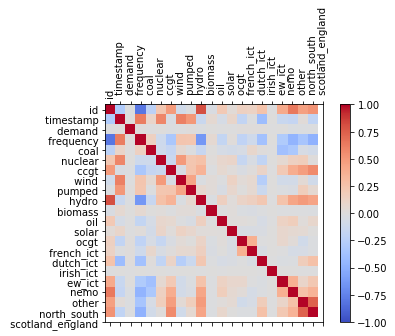

In [10]:
corr = raw_data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(raw_data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(raw_data.columns)
ax.set_yticklabels(raw_data.columns)
plt.show()

This is a heat map representing the strength of correlation coefficient across all features. Despite that in this particular occasion the heat map does not serve a significant purpose, because our data is time series observations and therefore, it is intuitive that the power consumption is likely to show seasonal periodicity and noise. 

### Obtain a summary statistics and visualisation of the response variable 
The next usual step is to obtain a summary statistics of the data set in order to investigate the necessity of features for rescaling or transformation.

In [11]:
data.describe()

count    874876.000000
mean      33439.486299
std        7260.635137
min           0.000000
25%       27819.000000
50%       32752.000000
75%       38596.000000
max      254852.000000
Name:  demand, dtype: float64

Since the question here concerns with future prediction of Power Consumption, we concentrate our focus on the trends and seasonality and forcast of the 'demand' variable in the data. Because predicting the demand of power consumtion is what we are looking for.

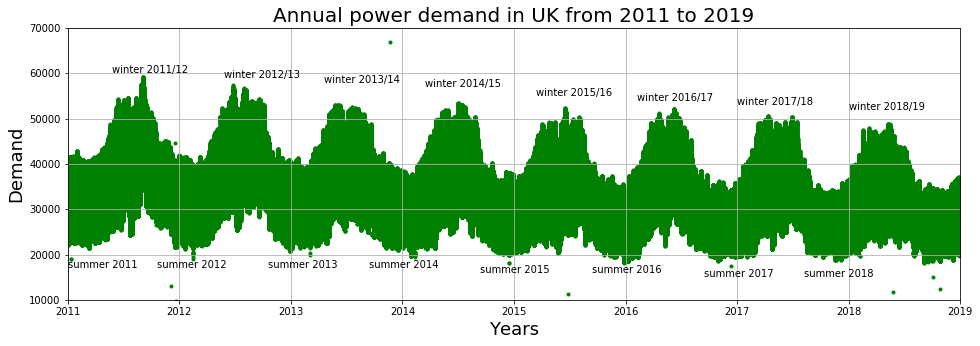

In [12]:
plt.figure(1, figsize = (16,5))

t_annual = np.linspace(2011, 2019, num=len(data.iloc[:,]))
x1 = data.iloc[:,]
plt.scatter(t_annual,x1,label='Annual Power Consumption',color='g', marker='.')
plt.title('Annual power demand in UK from 2011 to 2019',fontsize=20)
ax.set_xticks(np.arange(2011, 2019, 1))
plt.ylim((10000,70000))
plt.xlim((2011,2019))
plt.xlabel('Years',fontsize=18)
plt.ylabel('Demand',fontsize=18)
plt.text(2011.4, 60000, r'winter 2011/12',fontsize=10)
plt.text(2012.4, 59000, r'winter 2012/13',fontsize=10)
plt.text(2013.3, 58000, r'winter 2013/14',fontsize=10)
plt.text(2014.2, 57000, r'winter 2014/15',fontsize=10)
plt.text(2015.2, 55000, r'winter 2015/16',fontsize=10)
plt.text(2016.1, 54000, r'winter 2016/17',fontsize=10)
plt.text(2017, 53000, r'winter 2017/18',fontsize=10)
plt.text(2018, 52000, r'winter 2018/19',fontsize=10)
plt.text(2011, 17000, r'summer 2011',fontsize=10)
plt.text(2011.8, 17000, r'summer 2012',fontsize=10)
plt.text(2012.8, 17000, r'summer 2013',fontsize=10)
plt.text(2013.7, 17000, r'summer 2014',fontsize=10)
plt.text(2014.7, 16000, r'summer 2015',fontsize=10)
plt.text(2015.7, 16000, r'summer 2016',fontsize=10)
plt.text(2016.7, 15000, r'summer 2017',fontsize=10)
plt.text(2017.6, 15000, r'summer 2018',fontsize=10)
plt.grid(True)
plt.show()

This is the 8 years history of demand on the scale of years, which is useful for overviewing trends on the scale of annual power consumption. The periodic behaviour in this graph corresponds to the alternating consumption rate of power between summer and winter. The peaks corresponds to the higher consumption of power in winters and the troughs correspond to lower consumption of power in summer seasons, these are annotated in the figure. We can also plot this graph on a monthly scale for example for 9 months since January 2019 to the present (September 2019)

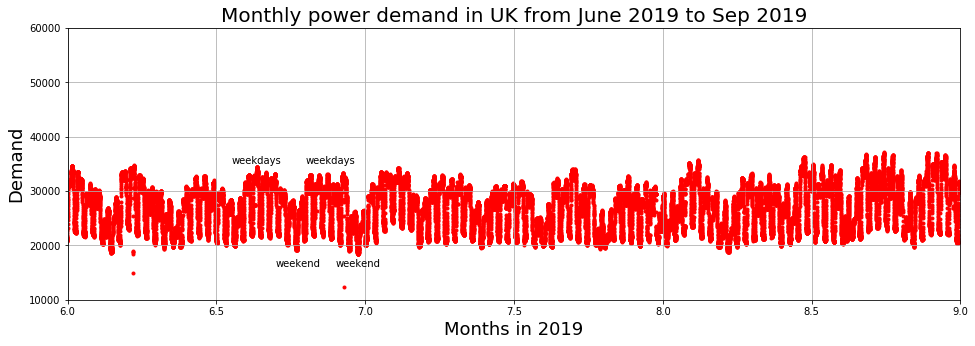

In [27]:
plt.figure(1, figsize = (16,5))

months_length = len(data.iloc[:,])-797116

t_monthly = np.linspace(1, 9, num=months_length)
x1 = data.iloc[797116:874876,]
plt.scatter(t_monthly,x1,label='Annual Power Consumption',color='r', marker='.')
plt.title('Monthly power demand in UK from June 2019 to Sep 2019',fontsize=20)
ax.set_xticks(np.arange(1, 9, 1))
plt.ylim((10000,60000))
plt.xlim((6,9))
plt.xlabel('Months in 2019',fontsize=18)
plt.text(6.55, 35000, r'weekdays',fontsize=10)
plt.text(6.8, 35000, r'weekdays',fontsize=10)
plt.text(6.7, 16000, r'weekend',fontsize=10)
plt.text(6.9, 16000, r'weekend',fontsize=10)
plt.ylabel('Demand',fontsize=18)
plt.grid(True)
plt.show()

This plot is showing the time series data for the 9 most recent months from January 2019 to September 2019. This plot will help to observe trends in the scale of months within a single year. We can also observe the data for the past two weeks, which will be useful to analyse and predict the behaviour of data consumption trends for a single week in the future. In the next graph we precisely achieve to see how the data consuption looks in order to a two weeks period, i.e. during the course of two most recent weeks. The trends and cyclic behaviour we see in the order of weeks will be of great importance for answering the question of forcasting.

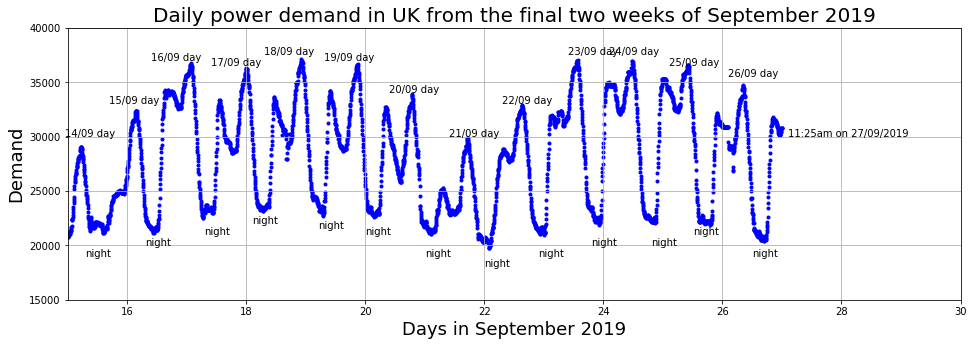

In [28]:
plt.figure(1, figsize = (16,5))

months_length = len(data.iloc[:,])-866812

t_monthly = np.linspace(1, 27, num=months_length)
x1 = data.iloc[866812:874876,]
plt.scatter(t_monthly,x1,label='Annual Power Consumption',color='b',marker='.')
plt.title('Daily power demand in UK from the final two weeks of September 2019',fontsize=20)
ax.set_xticks(np.arange(1, 30, 1))
plt.ylim((15000,40000))
plt.xlim((15,30))
plt.xlabel('Days in September 2019',fontsize=18)
plt.ylabel('Demand',fontsize=18)
plt.text(15.3, 19000, r'night',fontsize=10)
plt.text(16.3, 20000, r'night',fontsize=10)
plt.text(17.3, 21000, r'night',fontsize=10)
plt.text(18.1, 22000, r'night',fontsize=10)
plt.text(19.2, 21500, r'night',fontsize=10)
plt.text(20, 21000, r'night',fontsize=10)
plt.text(21.0, 19000, r'night',fontsize=10)
plt.text(22.0, 18000, r'night',fontsize=10)
plt.text(22.9, 19000, r'night',fontsize=10)
plt.text(23.8, 20000, r'night',fontsize=10)
plt.text(24.8, 20000, r'night',fontsize=10)
plt.text(25.5, 21000, r'night',fontsize=10)
plt.text(26.5, 19000, r'night',fontsize=10)

plt.text(14.95, 30000, r'14/09 day',fontsize=10)
plt.text(15.7, 33000, r'15/09 day',fontsize=10)
plt.text(16.4, 37000, r'16/09 day',fontsize=10)
plt.text(17.4, 36500, r'17/09 day',fontsize=10)
plt.text(18.3, 37500, r'18/09 day',fontsize=10)
plt.text(19.3, 37000, r'19/09 day',fontsize=10)
plt.text(20.4, 34000, r'20/09 day',fontsize=10)
plt.text(21.4, 30000, r'21/09 day',fontsize=10)
plt.text(22.3, 33000, r'22/09 day',fontsize=10)
plt.text(23.4, 37500, r'23/09 day',fontsize=10)
plt.text(24.1, 37500, r'24/09 day',fontsize=10)
plt.text(25.1, 36500, r'25/09 day',fontsize=10)
plt.text(26.1, 35500, r'26/09 day',fontsize=10)
plt.text(27.1, 30000, r'11:25am on 27/09/2019',fontsize=10)
plt.grid(True)
plt.show()

At this stage we can use fourier analysis to predict the consumption rate for the future one week. 

#### A note on normalisation 
 
Normalisation of the original data set is a very important step in particular when the data set contains features outside a mutually inclusive range. Here, we normalise dependent (response) variable which depends on a single variable time.Despite that it is not a crucially important requirement in Fourier analysis to always normalise the data set, because it can also work without normalisation. On this occasion we normalise the data set using the following function. We will apply fourier analysis to the normalised data set and rescale the results back to the range of the original raw data set.

In [29]:
def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom 

In [30]:

scaled_data = scale(raw_data.iloc[:,2:22],0,1)

In [31]:
scaled_data.head(1)

,demand,frequency,coal,nuclear,ccgt,wind,pumped,hydro,biomass,oil,solar,ocgt,french_ict,dutch_ict,irish_ict,ew_ict,nemo,other,north_south,scotland_england
0,0.152536,0.994623,0.368221,0.879628,0.671786,0.100594,0.108004,0.443515,0.0,0.0,0.0,0.0,0.55614,0.471002,0.095344,1.0,0.364811,0.0,0.314304,0.333168


### Fourier analysis and forcasting
Due to the periodic nature of the time series data, the most appropriate tool to forcast the future trend of this data set is to use Fourier analysis. We use the following function to accomplish fourier series extrapolation.

In [32]:
def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 500                    # number of fourier harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in data
    x_notrend = x - p[0] * t        # detrended the serie
    x_freqdom = fft.fft(x_notrend)  # detrended serie in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = range(n)
                                    # sort frequency in ascending order
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t
    
def main():
    x =  scaled_data.iloc[866812:874876,0]
    n_predict = 2016
    extrapolation = fourierExtrapolation(x, n_predict)
    pl.plot(np.arange(0, extrapolation.size), extrapolation, 'b', label = ' Scaled Prediction')
    pl.plot(np.arange(0, x.size), x, 'r', label = 'Scaled Data', linewidth = 3,marker='.',alpha=0.07)
    pl.title('Fitted model with normalised data set and prediction',fontsize=22)
    pl.xlabel('Time stamp number',fontsize=18)
    pl.ylabel('Scaled power demand',fontsize=18)
    ax.set_xticks(np.arange(1, 30, 1))
    pl.legend()
    pl.show()
    
plt.figure(1, figsize = (16,5))
    
if __name__ == "__main__":
    main()

AttributeError: 'range' object has no attribute 'sort'

<Figure size 1152x360 with 0 Axes>

After obtaining the prediction on the normalised data, we rescale the amplitude of each data points to the original scale of the raw data, in order to be able to read realistic values of predictions. The demand trajectory is predicted for 2016 time stamps (red) in the future. Note that 2016 time slices of 5 minute add up to 7 days. 

In [33]:
type(scaled_data)



pandas.core.frame.DataFrame

In [34]:
def main():
    x =  data.iloc[866812:874876,]
    n_predict = 2016-288 # This does not refer to the year 2016, but instead it refers to how many time stamps into the future we want to predict. One week equal to 2016 time intervals of 5 minutes
    extrapolation = fourierExtrapolation(x, n_predict)
    pl.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'Prediction')
    pl.plot(np.arange(0, x.size), x, 'g', label = 'Data', linewidth = 5,alpha=0.3,marker='.')
    pl.title('Fitted model of UK power demand and one week prediction',fontsize=22)
    pl.xlabel('Time stamp number',fontsize=18)
    pl.ylabel('Power demand',fontsize=18)
    plt.text(8000, 10000, r'11:25am on 27/09/2019',fontsize=10)
    plt.text(8000+700, 5000, r'11:24am on 03/10/2019',fontsize=10)
    plt.text(700, 17000, r'------Sep-Week1------',fontsize=15)
    plt.text(700+2016, 17000, r'------Sep-Week2------',fontsize=15)
    plt.text(700+2*2016, 17000, r'------Sep-Week3------',fontsize=15)
    plt.text(700+3*2016, 17000, r'------Sep-Week4------',fontsize=15)
    plt.text(700+3*2016+8*288, 17000, r'1st-Oct',fontsize=10)
    plt.text(450, 30000, r'01/09',fontsize=8)
    plt.text(2200, 31500, r'07/09',fontsize=8)
    plt.text(4200, 30000, r'14/09',fontsize=8)
    plt.text(6000, 34000, r'21/09',fontsize=8)
    plt.text(6000+2016, 34000, r'Fri',fontsize=8)
    plt.text(6000+2016+288, 32000, r'Sat',fontsize=8)
    plt.text(6000+2016+2*288, 33000, r'Sun',fontsize=8)
    plt.text(6000+2016+3*288, 36800, r'Mon',fontsize=8)
    plt.text(6000+2016+4*288, 37500, r'Tue',fontsize=8)
    plt.text(6000+2016+5*288, 35000, r'Wed',fontsize=8)
    plt.text(6000+2016+6*288, 35000, r'Thu',fontsize=8)
    # plt.text(8000+1000, 10000, r'11:24am on 03/10/2019',fontsize=10)
    plt.arrow(8100, 11000, 0, 18000)
    plt.arrow(8100+2000-288, 6000, 0, 26000)
    plt.arrow(700+3*2016+8.6*288, 18500, 0, 13000)
    #plt.ylim((15000,40000))
    ax.set_xticks(np.arange(1, 30, 1))
    pl.legend()
    pl.show()
    
plt.figure(1, figsize = (16,5))
    
if __name__ == "__main__":
    main()

AttributeError: 'range' object has no attribute 'sort'

<Figure size 1152x360 with 0 Axes>

There are a number of limitations and interesting properties of this data and these can be discussed in more details during the interview.

### Discussion
This solution utilises frequency decomposition method using fast fourier transform (FFT) to analyse the pattern of data in frequency domain and project the prediction in time domain. In brief the work flow is such that the data is preprocessed, normalised and decomposed into linear combination of fundamental harmonics. These harmonics are studied in frequency domain to compute the coefficients of constituent frequencies (high and low). The inverse of FFT with the newly computed set of parameters return the function of time, which predicts values of demand for future time stamps. This is a pure time series approach to predict the demand of power consumption, where no other features within the data set were used as predictors. 

#### Challenges in dealing with dataset
One challenge with the dataset was that the choice of method was not apparent at first without visualising the demand variable on the time axis, which was computationally synthesized using the record of time stamps. Other than that there were no particular challenges with the dataset, except that it is of size more comfortable to process on the server rather than personal PC, because if this prediction was programmed using logistic regression or other computationally costy algorithms that include all the features then it would easily tire out the RAM. It was a 'good' dataset in the sense that there were no missing values throughout the frame. The feature names were consistently small case format with no space inside feature names. The time stamps between subsequent 'demand' observations are 5 minutes which is sufficiently small and certainly contributes to the predictive accuracy of demand. 

#### Challenges in modelling the dataset
It was helpful in the choosing the method to observe that the dataset exposes sufficiently regular cyclic pattern, which shows a highly compound combination of mixed frequencies. Datasets with seasonal periodicity along the time axis are perfect candidates for the application of Fourier analysis. It is worth mentioning that this type of prediction method is specific for datasets with periodic patterns. If dataset is not of periodic nature then other methods such as deep learning, logistic regression and so forth can be applied. The heat map was produced not that it was required for the method of fourier analysis, instead it was just as additional graphical test of statistical independencies across the features of the dataset. 

#### Weakness and strengths of the model
Due to the stable consistency and periodic nature of this dataset, fourier analysis provides the most robust and reliable predictive power. The strength of this method lies within the robustness of its application is almost all types of time series data analysis. The robustness of the application of fourier transform is heavily data dependent in the sense that datasets with no consistency in pattern are difficult to predict using this method, which is a weakness of this model. 

#### Interesting features of the dataset
There are a few levels of seasonal patterns observed in the demand variables. On the annual scale we can observe the winter/summer periodicity indicated within the Figure for Annual data. In the period of a single year i.e. on monthly scale we can observe the patterns that resembles the two weekend days creating troughs and the 5 working days that creat peaks, these are also annotated within the Monthly figure. Similarly there is a daily level of periodicity which represent the decrease of power demand in nights compared to day times, this is also annotated in the daily plot. The predicted set of values are stored in the variable 'extrapolation'.